# Libraries

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import altair as alt
from pickle import dump

# Setup

In [2]:
file_name = "data.csv"
df = pd.read_csv(file_name, encoding='UTF-16 LE')
df['index'] = df.index
print("Number of rows and columns:", df.shape)
TRAINING_SIZE = 20000
TEST_SIZE = df.shape[0] - TRAINING_SIZE

FORECASTING_WINDOW = 30
PAST_WINDOW = 60

SCALER = True

Number of rows and columns: (23823, 8)


In [3]:
df = df.replace(to_replace=0, method='ffill')  # fill internal NaN with previous non-NaN value

df.tail()

,name,time,gps,humidity,id,strength,temperature,index
23818,quanto,1632925406506501888,41 53 25.36 - 12 29 32.70,43.1,ID1,-43,32.3,23818
23819,quanto,1632925407520123648,41 53 25.36 - 12 29 32.70,43.1,ID1,-46,32.3,23819
23820,quanto,1632925408580872960,41 53 25.36 - 12 29 32.70,43.1,ID1,-41,32.3,23820
23821,quanto,1632925409559711744,41 53 25.36 - 12 29 32.70,43.1,ID1,-40,32.3,23821
23822,quanto,1632925410578413824,41 53 25.36 - 12 29 32.70,43.2,ID1,-40,32.3,23822


# Temperature forecasting

In [4]:
# TEMPERATURE MODEL

training_set_temp = df.iloc[:TRAINING_SIZE, 6:7].values
test_set_temp = df.iloc[TRAINING_SIZE:TRAINING_SIZE+TEST_SIZE, 6:7].values

# Feature Scaling
if SCALER:
    sc_t = MinMaxScaler(feature_range = (0, 1))
    training_set_temp = sc_t.fit_transform(training_set_temp)
    dump(sc_t, open('scaler_t.pkl', 'wb'))
#training_set = training_set

# Creating a data structure with 60 time-steps and 1 output
X_train_temp = []
y_train_temp = []

for i in range(PAST_WINDOW, len(training_set_temp) - FORECASTING_WINDOW):
    X_train_temp.append(training_set_temp[i-PAST_WINDOW:i, 0])
    y_train_temp.append(training_set_temp[i:(i+FORECASTING_WINDOW), 0])

X_train_temp, y_train_temp = np.array(X_train_temp), np.array(y_train_temp)
X_train_temp = np.reshape(X_train_temp, (X_train_temp.shape[0], X_train_temp.shape[1], 1))


# Feature Scaling
if SCALER:
    test_set_temp = sc_t.fit_transform(test_set_temp)
#training_set = training_set

# Creating a data structure with 60 time-steps and 30 outputs
X_test_temp = []
y_test_temp = []

for i in range(PAST_WINDOW, len(test_set_temp) - FORECASTING_WINDOW):
    X_test_temp.append(test_set_temp[i-PAST_WINDOW:i, 0])
    y_test_temp.append(test_set_temp[i: (i+FORECASTING_WINDOW), 0])

X_test_temp, y_test_temp = np.array(X_test_temp), np.array(y_test_temp)
X_test_temp = np.reshape(X_test_temp, (X_test_temp.shape[0], X_test_temp.shape[1], 1))



In [5]:
model_temp = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model_temp.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train_temp.shape[1], 1)))
model_temp.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model_temp.add(LSTM(units = 32, return_sequences = True))
model_temp.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model_temp.add(LSTM(units = 32))
model_temp.add(Dropout(0.2))
# Adding the output layer
model_temp.add(Dense(units = FORECASTING_WINDOW))

# Compiling the RNN
model_temp.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [6]:
# callbacks

patience = 2
min_lr = 1e-10
lr_reduction_factor = 0.1
patience_reduce_lr = 3

callback1 = tf.keras.callbacks.ModelCheckpoint('weights_temp.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              save_weights_only=True,
                                              verbose=1)

callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

callback3 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=lr_reduction_factor,
                                                      patience=patience_reduce_lr, min_lr=min_lr)



callbacks=[callback1, callback2, callback3]

In [7]:
# Fitting the RNN to the Training set
model_temp.fit(X_train_temp, y_train_temp, epochs = 10, batch_size = 32, callbacks=callbacks, validation_data = (X_test_temp, y_test_temp))

Epoch 1/20
623/623 [==============================] - 33s 45ms/step - loss: 0.0181 - val_loss: 0.0045

Epoch 00001: val_loss improved from inf to 0.00452, saving model to weights_temp.hdf5
Epoch 2/20
623/623 [==============================] - 27s 43ms/step - loss: 0.0038 - val_loss: 0.0040

Epoch 00002: val_loss improved from 0.00452 to 0.00398, saving model to weights_temp.hdf5
Epoch 3/20
623/623 [==============================] - 27s 43ms/step - loss: 0.0026 - val_loss: 0.0036

Epoch 00003: val_loss improved from 0.00398 to 0.00365, saving model to weights_temp.hdf5
Epoch 4/20
623/623 [==============================] - 26s 42ms/step - loss: 0.0021 - val_loss: 0.0037

Epoch 00004: val_loss did not improve from 0.00365
Epoch 5/20
623/623 [==============================] - 26s 42ms/step - loss: 0.0017 - val_loss: 0.0034

Epoch 00005: val_loss improved from 0.00365 to 0.00345, saving model to weights_temp.hdf5
Epoch 6/20
623/623 [==============================] - 26s 42ms/step - loss: 0.

In [8]:
# Save model weights
model_temp.save_weights("weights_temp.h5")

In [11]:
predicted_train_temp = model_temp.predict(X_train_temp)
predicted_test_temp = model_temp.predict(X_test_temp)

#######################################################################
# Revert scaling

predicted_train_temp = sc_t.inverse_transform(predicted_train_temp)
predicted_test_temp = sc_t.inverse_transform(predicted_test_temp)

true_train_temp = sc_t.inverse_transform(y_train_temp)
true_test_temp = sc_t.inverse_transform(y_test_temp)

In [55]:
FORECASTING_SLICE = 29

In [56]:
print(len(predicted_test_temp),len(predicted_test_temp[0]))
print(len(true_test_temp),len(true_test_temp[0]))

3733 30
3733 30


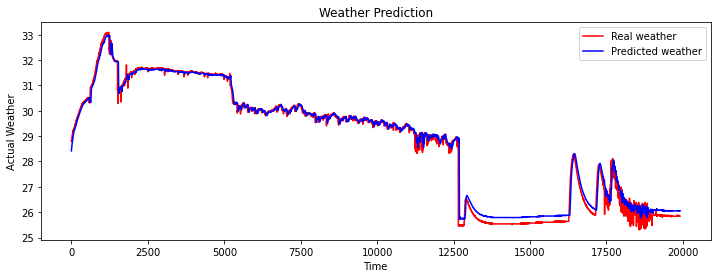

In [57]:
# Visualizing the results
plt.figure(figsize=(12,4))
plt.plot(true_train_temp[:,FORECASTING_SLICE], color = "red", label = "Real weather")
plt.plot(predicted_train_temp[:,FORECASTING_SLICE], color = "blue", label = "Predicted weather")
#plt.xticks(np.arange(0,len(test_set_temp),100))
plt.title('Weather Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Weather')
plt.legend()
plt.show()

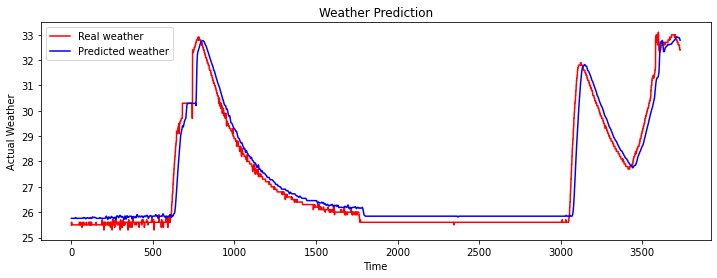

In [90]:
# Visualizing the results
plt.figure(figsize=(12,4))
plt.plot(true_test_temp[:,FORECASTING_SLICE], color = "red", label = "Real weather")
plt.plot(predicted_test_temp[:,FORECASTING_SLICE], color = "blue", label = "Predicted weather")
#plt.xticks(np.arange(0,len(test_set_temp),100))
plt.title('Weather Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Weather')
plt.legend()
plt.show()

 Interactive visualization with Altair

In [95]:
alt.data_transformers.disable_max_rows()

df_temp_true = pd.DataFrame(true_train_temp[:,FORECASTING_SLICE],columns = ['y'])
df_temp_true['x'] = df_temp_true.index

df_temp_pred = pd.DataFrame(predicted_train_temp[FORECASTING_SLICE:,FORECASTING_SLICE],columns = ['y'])
df_temp_pred['x'] = df_temp_pred.index

#scale = alt.Scale(domain=['FeatureOne', 'FeatureTwo'], range=['gold', 'red'])
#############################################################
temp_true_chart = alt.Chart(df_temp_true, title='True').mark_line().transform_fold(
    fold=['True'], 
    as_=['variable', 'value']).encode(
    
    alt.X("x:Q"),
    alt.Y("y:Q",scale=alt.Scale(domain=(25, 35))),
    color='variable:N'

    ).properties(width = 900,height = 300).interactive(bind_y = True)
#############################################################
temp_pred_chart = alt.Chart(df_temp_pred, title='Predicted').mark_line(color="#FFAA00").transform_fold(
    fold=['Predicted'], 
    as_=['variable', 'value']).encode(
    
    alt.X("x:Q"),
    alt.Y("y:Q",scale=alt.Scale(domain=(25, 35))),
    color='variable:N'

    ).properties(width = 900,height = 300).interactive(bind_y = True)  


In [96]:
(temp_pred_chart + temp_true_chart)

alt.LayerChart(...)

# Humidity forecasting

In [61]:
# HUMIDITY MODEL

training_set_hum = df.iloc[:TRAINING_SIZE, 3:4].values
test_set_hum = df.iloc[TRAINING_SIZE:TRAINING_SIZE+TEST_SIZE, 3:4].values

# Feature Scaling
if SCALER:
    sc_h = MinMaxScaler(feature_range = (0, 1))
    training_set_hum = sc_h.fit_transform(training_set_hum)
    dump(sc_h, open('scaler_h.pkl', 'wb'))
#training_set = training_set

# Creating a data structure with 60 time-steps and 1 output
X_train_hum = []
y_train_hum = []

for i in range(PAST_WINDOW, len(training_set_hum) - FORECASTING_WINDOW):
    X_train_hum.append(training_set_hum[i-PAST_WINDOW:i, 0])
    y_train_hum.append(training_set_hum[i:(i+FORECASTING_WINDOW), 0])

X_train_hum, y_train_hum = np.array(X_train_hum), np.array(y_train_hum)
X_train_hum = np.reshape(X_train_hum, (X_train_hum.shape[0], X_train_hum.shape[1], 1))

# Feature Scaling
if SCALER:
    test_set_hum = sc_h.fit_transform(test_set_hum)
#training_set = training_set

# Creating a data structure with 60 time-steps and 1 output
X_test_hum = []
y_test_hum = []

for i in range(PAST_WINDOW, len(test_set_hum) - FORECASTING_WINDOW):
    X_test_hum.append(test_set_hum[i-PAST_WINDOW:i, 0])
    y_test_hum.append(test_set_hum[i: (i+FORECASTING_WINDOW), 0])

X_test_hum, y_test_hum = np.array(X_test_hum), np.array(y_test_hum)
X_test_hum = np.reshape(X_test_hum, (X_test_hum.shape[0], X_test_hum.shape[1], 1))



In [62]:
model_hum = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model_hum.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train_hum.shape[1], 1)))
model_hum.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model_hum.add(LSTM(units = 32, return_sequences = True))
model_hum.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model_hum.add(LSTM(units = 32))
model_hum.add(Dropout(0.2))
# Adding the output layer
model_hum.add(Dense(units = FORECASTING_WINDOW))

# Compiling the RNN
model_hum.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [63]:
# callbacks

patience = 2
min_lr = 1e-10
lr_reduction_factor = 0.1
patience_reduce_lr = 3

callback1 = tf.keras.callbacks.ModelCheckpoint('weights_hum.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              save_weights_only=True,
                                              verbose=1)

callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

callback3 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=lr_reduction_factor,
                                                      patience=patience_reduce_lr, min_lr=min_lr)



callbacks=[callback1, callback2, callback3]

In [64]:
# Fitting the RNN to the Training set
model_hum.fit(X_train_hum, y_train_hum, epochs = 10, batch_size = 32, callbacks=callbacks, validation_data = (X_test_hum, y_test_hum))

Epoch 1/20
623/623 [==============================] - 32s 43ms/step - loss: 0.0091 - val_loss: 0.0110

Epoch 00001: val_loss improved from inf to 0.01100, saving model to weights_hum.hdf5
Epoch 2/20
623/623 [==============================] - 26s 42ms/step - loss: 0.0029 - val_loss: 0.0106

Epoch 00002: val_loss improved from 0.01100 to 0.01064, saving model to weights_hum.hdf5
Epoch 3/20
623/623 [==============================] - 26s 42ms/step - loss: 0.0023 - val_loss: 0.0102

Epoch 00003: val_loss improved from 0.01064 to 0.01024, saving model to weights_hum.hdf5
Epoch 4/20
623/623 [==============================] - 26s 42ms/step - loss: 0.0021 - val_loss: 0.0102

Epoch 00004: val_loss improved from 0.01024 to 0.01024, saving model to weights_hum.hdf5
Epoch 5/20
623/623 [==============================] - 26s 42ms/step - loss: 0.0019 - val_loss: 0.0090

Epoch 00005: val_loss improved from 0.01024 to 0.00902, saving model to weights_hum.hdf5
Epoch 6/20
623/623 [========================

In [65]:
# Save model weights
model_hum.save_weights("weights_hum.h5")

In [66]:
predicted_train_hum = model_hum.predict(X_train_hum)
predicted_test_hum = model_hum.predict(X_test_hum)

#######################################################################
# Revert scaling

predicted_train_hum = sc_h.inverse_transform(predicted_train_hum)
predicted_test_hum = sc_h.inverse_transform(predicted_test_hum)

true_train_hum = sc_h.inverse_transform(y_train_hum)
true_test_hum = sc_h.inverse_transform(y_test_hum)

In [67]:
FORECASTING_SLICE = 20

In [68]:
print(len(predicted_test_hum),len(predicted_test_hum[0]))
print(len(true_test_hum),len(true_test_hum[0]))

3733 30
3733 30


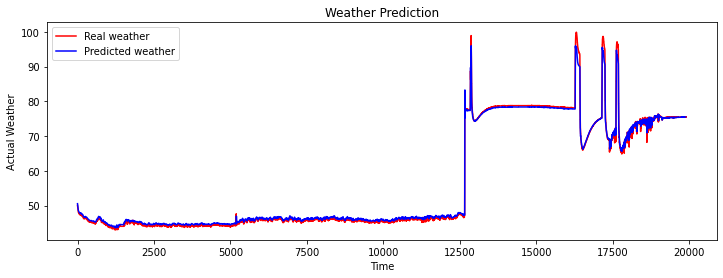

In [74]:
# Visualizing the results
plt.figure(figsize=(12,4))
plt.plot(true_train_hum[:,FORECASTING_SLICE], color = "red", label = "Real weather")
plt.plot(predicted_train_hum[FORECASTING_SLICE:,FORECASTING_SLICE], color = "blue", label = "Predicted weather")
#plt.xticks(np.arange(0,len(test_set_hum),100))
plt.title('Weather Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Weather')
plt.legend()
plt.show()

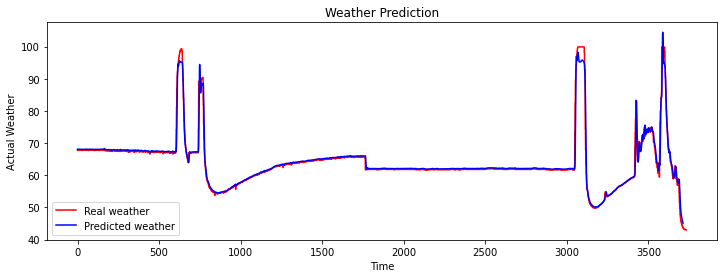

In [73]:
# Visualizing the results
plt.figure(figsize=(12,4))
plt.plot(true_test_hum[:,FORECASTING_SLICE], color = "red", label = "Real weather")
plt.plot(predicted_test_hum[FORECASTING_SLICE:,FORECASTING_SLICE], color = "blue", label = "Predicted weather")
#plt.xticks(np.arange(0,len(test_set_hum),100))
plt.title('Weather Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Weather')
plt.legend()
plt.show()

Interactive visualization with Altair

In [83]:
alt.data_transformers.disable_max_rows()

df_hum_true = pd.DataFrame(true_test_hum[:,FORECASTING_SLICE],columns = ['y'])
df_hum_true['x'] = df_hum_true.index

df_hum_pred = pd.DataFrame(predicted_test_hum[FORECASTING_SLICE:,FORECASTING_SLICE],columns = ['y'])
df_hum_pred['x'] = df_hum_pred.index

#scale = alt.Scale(domain=['FeatureOne', 'FeatureTwo'], range=['gold', 'red'])
#############################################################
hum_true_chart = alt.Chart(df_hum_true, title='True').mark_line().transform_fold(
    fold=['True'], 
    as_=['variable', 'value']).encode(
    
    alt.X("x:Q"),
    alt.Y("y:Q",scale=alt.Scale(domain=(35, 105))),
    color='variable:N'

    ).properties(width = 900,height = 300).interactive(bind_y = True)
#############################################################
hum_pred_chart = alt.Chart(df_hum_pred, title='Predicted').mark_line(color="#FFAA00").transform_fold(
    fold=['Predicted'], 
    as_=['variable', 'value']).encode(
    
    alt.X("x:Q"),
    alt.Y("y:Q",scale=alt.Scale(domain=(40, 35))),
    color='variable:N'

    ).properties(width = 900,height = 300).interactive(bind_y = True)  

In [84]:
(hum_pred_chart + hum_true_chart)

alt.LayerChart(...)